# Mechanisms of Action (MoA) Prediction
*Done by Océane Salmeron, Baptiste Lafay, Nathan Lancman, Charles Mabbyalas (ING5 BDA2)*

# Set up

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


## Import tensorflow

In [23]:
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing

!pip3 install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from matplotlib import pyplot as plt

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [24]:
import pathlib
import tempfile

# Data reading

### 1. Use Pandas to create a dataframe

#### Setting our batch size

In [25]:
BATCH_SIZE = 32

#### Create dataframe for features and targets

In [26]:
features = pd.read_csv("/kaggle/input/lish-moa/train_features.csv", nrows=20)
targets = pd.read_csv("/kaggle/input/lish-moa/train_targets_scored.csv", nrows=20)

cols_features = features.columns
cols_targets = targets.columns

num_features = len(cols_features)
num_targets = len(cols_targets)

print("Number of features:" , num_features)
print("Number of targets:" , num_targets)

Number of features: 876
Number of targets: 207


In [27]:
gcols = [g for g in features.columns if "g-" in g]
ccols = [c for c in features.columns if "c-" in c]

In [28]:
features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [29]:
targets.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Building data pipelins

In [30]:
features_types = [str(), str(), str(), str()] + [float()]*(num_features-4)
targets_types = [str()] + [float()]*(num_targets-1)

features = tf.data.experimental.CsvDataset("/kaggle/input/lish-moa/train_features.csv",
                                           record_defaults=features_types,
                                           header=True)

targets = tf.data.experimental.CsvDataset("/kaggle/input/lish-moa/train_targets_scored.csv",
                                          record_defaults=targets_types,
                                          header=True)

dataset = tf.data.Dataset.zip((features, targets))

In [31]:
# split dataset into train and val
dataset_size = dataset.reduce(0, lambda x, _: x + 1).numpy()

train_size = int(0.7*dataset_size)
val_size = dataset_size - train_size

train = dataset.take(train_size)
val = dataset.skip(train_size)
val = dataset.take(val_size)

train_size = train.reduce(0, lambda x, _: x + 1).numpy()
val_size = val.reduce(0, lambda x, _: x + 1).numpy()

print("Full dataset size:", dataset_size)
print("Train dataset size:", train_size)
print("Val dataset size:", val_size)

Full dataset size: 23814
Train dataset size: 16669
Val dataset size: 7145


In [32]:
def _preprocess_line(features, targets):
    # Pack the result into a dictionary
    features = dict(zip(cols_features, features))
    features.pop('sig_id')

    targets = tf.stack(targets[1:])
    
    return features, targets

train = train.map(_preprocess_line)
train = train.batch(BATCH_SIZE)

val = val.map(_preprocess_line)
val = val.batch(BATCH_SIZE)

In [33]:
for feature_batch, label_batch in train.take(1):
    print('First 5 features:', list(feature_batch.keys())[:5])
    print('A batch of cp_types:', feature_batch['cp_type'].numpy())
    print('A batch of cp_times:', feature_batch['cp_time'].numpy())
    print('A batch of targets:', label_batch.numpy() )

First 5 features: ['cp_type', 'cp_time', 'cp_dose', 'g-0', 'g-1']
A batch of cp_types: [b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'ctl_vehicle' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp']
A batch of cp_times: [b'24' b'72' b'48' b'48' b'72' b'24' b'24' b'48' b'48' b'48' b'72' b'48'
 b'48' b'48' b'72' b'48' b'48' b'24' b'72' b'48' b'48' b'48' b'72' b'72'
 b'72' b'48' b'72' b'48' b'48' b'72' b'72' b'48']
A batch of targets: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Feature Engineering

Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. 

#### Prepare encoded features array

In [34]:
feature_columns = []

### 1. Normalization of numerical columns

In [35]:
for name in (gcols + ccols):
    feature_columns.append(feature_column.numeric_column(name))

### 2. Encoding of categorical columns

In [36]:
cp_time_type = feature_column.categorical_column_with_vocabulary_list(
      'cp_time', ['24', '48', '72'])
cp_type_type = feature_column.categorical_column_with_vocabulary_list(
      'cp_type', ['trt_cp', 'ctl_vehicle'])
cp_dose_type = feature_column.categorical_column_with_vocabulary_list(
      'cp_dose', ['D1', 'D2'])

cp_time_type_one_hot = feature_column.indicator_column(cp_time_type)
cp_type_type_one_hot = feature_column.indicator_column(cp_type_type)
cp_dose_type_one_hot = feature_column.indicator_column(cp_dose_type)

feature_columns.append(cp_time_type_one_hot)
feature_columns.append(cp_type_type_one_hot)
feature_columns.append(cp_dose_type_one_hot)

### 3. Model training

In [37]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [38]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(206)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.fit(train,
          validation_data=val,
          epochs=10)

Epoch 1/10
521/521 [==============================] - 51s 97ms/step - loss: 0.0388 - accuracy: 0.0691 - val_loss: 0.0176 - val_accuracy: 0.1019
Epoch 2/10
521/521 [==============================] - 44s 84ms/step - loss: 0.0173 - accuracy: 0.1129 - val_loss: 0.0155 - val_accuracy: 0.1321
Epoch 3/10
521/521 [==============================] - 44s 85ms/step - loss: 0.0155 - accuracy: 0.1328 - val_loss: 0.0140 - val_accuracy: 0.1565
Epoch 4/10
521/521 [==============================] - 43s 83ms/step - loss: 0.0141 - accuracy: 0.1560 - val_loss: 0.0128 - val_accuracy: 0.1808
Epoch 5/10
521/521 [==============================] - 45s 87ms/step - loss: 0.0128 - accuracy: 0.1821 - val_loss: 0.0115 - val_accuracy: 0.2165
Epoch 6/10
521/521 [==============================] - 43s 83ms/step - loss: 0.0116 - accuracy: 0.2131 - val_loss: 0.0103 - val_accuracy: 0.2542
Epoch 7/10
521/521 [==============================] - 45s 87ms/step - loss: 0.0103 - accuracy: 0.2532 - val_loss: 0.0090 - val_accuracy:

In [40]:
loss, accuracy = model.evaluate(val)
print("Accuracy", accuracy)

224/224 [==============================] - 12s 53ms/step - loss: 0.0060 - accuracy: 0.4020
Accuracy 0.4019594192504883


In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_1 (DenseFeatu multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  112640    
_________________________________________________________________
dense_4 (Dense)              multiple                  16512     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  26574     
Total params: 155,726
Trainable params: 155,726
Non-trainable params: 0
_________________________________________________________________


# Baseline modelling

In [42]:
regularizer_histories = {}
history = {}

In [43]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [44]:
def compile_and_fit(model, name, max_epochs=10):

    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                  metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                           'accuracy'])


    history = model.fit(
        train,
        epochs=max_epochs,
        validation_data=val,
        callbacks=get_callbacks(name),
        verbose=1)

    model.summary()
    
    return history

In [45]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"

### 1. L2 Regularization
Regularization refers to a set of different techniques that lower the complexity of a neural network model during training, and thus prevent the overfitting. The L2 regularization is the most common type of all regularization techniques and is also commonly known as weight decay or Ride Regression.

In [46]:
l2_model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu',
               kernel_regularizer=regularizers.l2(0.00001),
               input_shape=(num_features,)),
  layers.Dense(128, activation='relu', 
               kernel_regularizer=regularizers.l2(0.00001)),
  layers.Dense(206)
])


regularizer_histories['l2'] = compile_and_fit(l2_model, 'l2')

Epoch 1/10
    520/Unknown - 28s 54ms/step - loss: 0.0390 - binary_crossentropy: 0.0355 - accuracy: 0.0792- 28s 54ms/step - loss: 0.0390 - binary_crossentropy: 0.0355 - accuracy: 0.079
Epoch: 0, accuracy:0.0793,  binary_crossentropy:0.0354,  loss:0.0389,  val_accuracy:0.1136,  val_binary_crossentropy:0.0175,  val_loss:0.0208,  
521/521 [==============================] - 53s 101ms/step - loss: 0.0389 - binary_crossentropy: 0.0354 - accuracy: 0.0793 - val_loss: 0.0208 - val_binary_crossentropy: 0.0175 - val_accuracy: 0.1136
Epoch 2/10
521/521 [==============================] - 44s 85ms/step - loss: 0.0197 - binary_crossentropy: 0.0167 - accuracy: 0.1165 - val_loss: 0.0184 - val_binary_crossentropy: 0.0156 - val_accuracy: 0.1296
Epoch 3/10
521/521 [==============================] - 45s 86ms/step - loss: 0.0179 - binary_crossentropy: 0.0152 - accuracy: 0.1408 - val_loss: 0.0172 - val_binary_crossentropy: 0.0147 - val_accuracy: 0.1496
Epoch 4/10
521/521 [==============================] - 44

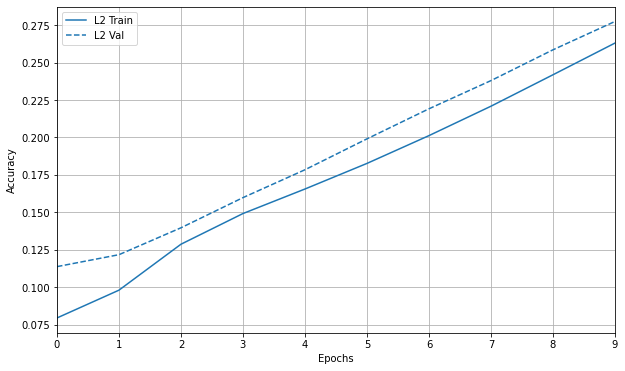

In [47]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plt.figure(figsize=(10, 6))
plotter.plot(regularizer_histories)

The model with L2 Regularization has low variance as the training and validation curves are close. This means there are small changes to the estimate of the target function with changes to the training dataset.

### 2. Drop out regularization
Drop out is a regularization technique for reducing overfitting in artificial neural networks by preventing complex co-adaptations on training data. It is an efficient way of performing model averaging with neural networks.

In [48]:
dp_model = tf.keras.Sequential([   
    feature_layer,
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(206)
])

In [49]:
regularizer_histories['drop_out'] = compile_and_fit(dp_model, 'drop_out')

Epoch 1/10
    520/Unknown - 29s 55ms/step - loss: 0.0387 - binary_crossentropy: 0.0387 - accuracy: 0.0700
Epoch: 0, accuracy:0.0701,  binary_crossentropy:0.0387,  loss:0.0387,  val_accuracy:0.1022,  val_binary_crossentropy:0.0176,  val_loss:0.0176,  
521/521 [==============================] - 52s 99ms/step - loss: 0.0387 - binary_crossentropy: 0.0387 - accuracy: 0.0701 - val_loss: 0.0176 - val_binary_crossentropy: 0.0176 - val_accuracy: 0.1022
Epoch 2/10
521/521 [==============================] - 44s 85ms/step - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.1087 - val_loss: 0.0156 - val_binary_crossentropy: 0.0156 - val_accuracy: 0.1244
Epoch 3/10
521/521 [==============================] - 44s 84ms/step - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.1241 - val_loss: 0.0145 - val_binary_crossentropy: 0.0145 - val_accuracy: 0.1485
Epoch 4/10
521/521 [==============================] - 45s 87ms/step - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.1463 - v

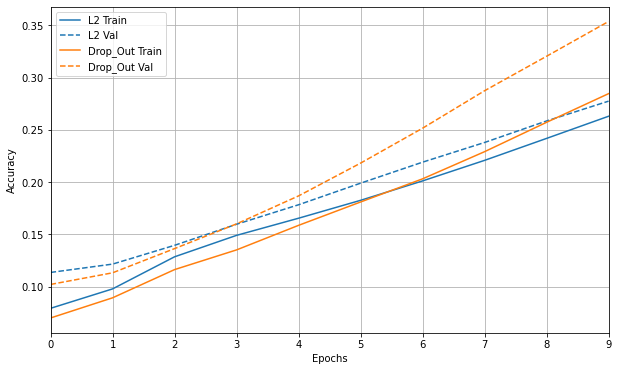

In [50]:
plt.figure(figsize=(10, 6))
plotter.plot(regularizer_histories)

The drop out regularization has high variance compare to the L2 regularization as you can see on the plot the training and validation curves starting to spread. This suggests large changes to the estimate of the target function with changes to the training dataset.

### 3. Batch Normalization
Batch normalization is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling.

In [51]:
batch_model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(206)
])

In [52]:
regularizer_histories['bacth'] = compile_and_fit(dp_model, 'batch')

Epoch 1/10
    521/Unknown - 29s 55ms/step - loss: 0.0083 - binary_crossentropy: 0.0083 - accuracy: 0.3184
Epoch: 0, accuracy:0.3184,  binary_crossentropy:0.0083,  loss:0.0083,  val_accuracy:0.4003,  val_binary_crossentropy:0.0062,  val_loss:0.0062,  
521/521 [==============================] - 51s 98ms/step - loss: 0.0083 - binary_crossentropy: 0.0083 - accuracy: 0.3184 - val_loss: 0.0062 - val_binary_crossentropy: 0.0062 - val_accuracy: 0.4003
Epoch 2/10
521/521 [==============================] - 45s 86ms/step - loss: 0.0074 - binary_crossentropy: 0.0074 - accuracy: 0.3496 - val_loss: 0.0054 - val_binary_crossentropy: 0.0054 - val_accuracy: 0.4258
Epoch 3/10
521/521 [==============================] - 43s 83ms/step - loss: 0.0068 - binary_crossentropy: 0.0068 - accuracy: 0.3723 - val_loss: 0.0049 - val_binary_crossentropy: 0.0049 - val_accuracy: 0.4442
Epoch 4/10
521/521 [==============================] - 45s 86ms/step - loss: 0.0063 - binary_crossentropy: 0.0063 - accuracy: 0.3897 - v

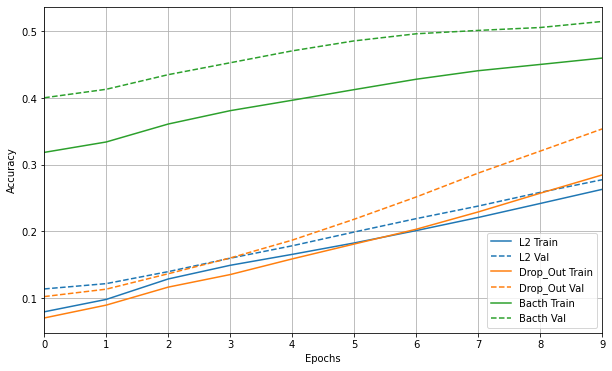

In [53]:
plt.figure(figsize=(10, 6))
plotter.plot(regularizer_histories)

The batch normalization also has high variance for the same reason explained for the drop out regularization.

### 4. Weight initialization

### 5. Batch + Drop out
Despite the fact that the bacth normalization and the drop out regularization have both high variance, they were models with the best accuracy. This is why for this part we decided to combine both scenarios.

In [54]:
all_model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'), 
    layers.Dropout(.1),
    layers.Dense(206)
])

In [55]:
regularizer_histories['all'] = history['last_model'] = compile_and_fit(dp_model, 'all')

Epoch 1/10
    521/Unknown - 29s 55ms/step - loss: 0.0042 - binary_crossentropy: 0.0042 - accuracy: 0.4678
Epoch: 0, accuracy:0.4678,  binary_crossentropy:0.0042,  loss:0.0042,  val_accuracy:0.5254,  val_binary_crossentropy:0.0021,  val_loss:0.0021,  
521/521 [==============================] - 52s 100ms/step - loss: 0.0042 - binary_crossentropy: 0.0042 - accuracy: 0.4678 - val_loss: 0.0021 - val_binary_crossentropy: 0.0021 - val_accuracy: 0.5254
Epoch 2/10
521/521 [==============================] - 45s 87ms/step - loss: 0.0039 - binary_crossentropy: 0.0039 - accuracy: 0.4690 - val_loss: 0.0019 - val_binary_crossentropy: 0.0019 - val_accuracy: 0.5257
Epoch 3/10
521/521 [==============================] - 44s 85ms/step - loss: 0.0037 - binary_crossentropy: 0.0037 - accuracy: 0.4795 - val_loss: 0.0018 - val_binary_crossentropy: 0.0018 - val_accuracy: 0.5278
Epoch 4/10
521/521 [==============================] - 46s 88ms/step - loss: 0.0036 - binary_crossentropy: 0.0036 - accuracy: 0.4844 - 

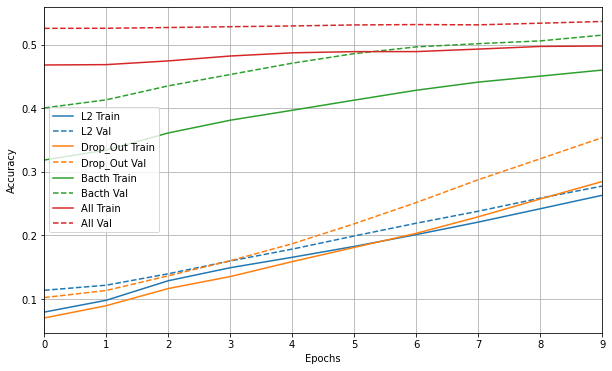

In [56]:
plt.figure(figsize=(10, 6))
plotter.plot(regularizer_histories)

# Model Variance & Bias Analysis
For this part we decided to use the last model we compiled and fitted : Batch normalization + Drop out regularizatio. This model also give us the best accuracy so far.

### 1. Plot the training and validation loss

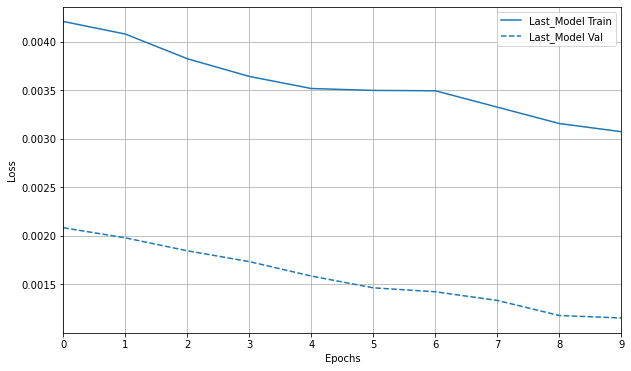

In [57]:
plot_loss = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plt.figure(figsize=(10, 6))
plot_loss.plot(history)
plt.ylim([0, 0.7])

### 2. Learning curve

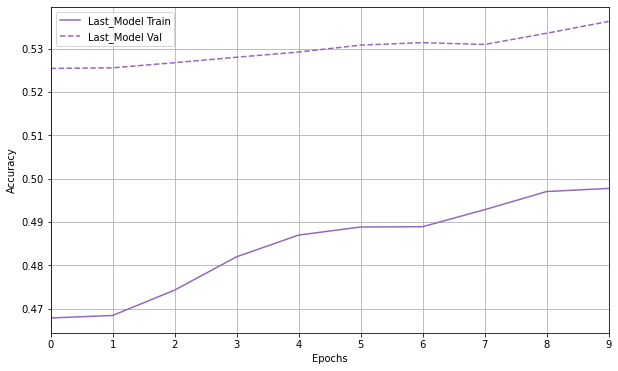

In [58]:
plt.figure(figsize=(10, 6))
plotter.plot(history)

## 3. Bias and Variance diagnosis
The validation dataset loss is much lower than the training dataset loss. This reflects that the validation dataset is much easier to predict than the training one. It can be explained by the fact that the validation dataset is widely represented by the the training dataset.

The learning curve shows that the training and validation curves starts to spread. This suggests large changes to the estimate of the target function with changes to the training dataset. Once again this also suggest high variance.

# Hyperparameter tuning with Keras Tuner

In [59]:
!pip install -q -U keras-tuner
import kerastuner as kt
import IPython

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


**This is the model we will be using for this execution. This is a simple model where we tune units, drop out and learning rate.**

In [60]:
def model_builder(hp):
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    hp_drop_out = hp.Choice('drop_out', values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7])

    hp_model = tf.keras.Sequential([
        feature_layer,
        layers.Dense(units = hp_units, activation='relu'),
        layers.Dense(units = hp_units, activation='relu'),
        layers.Dropout(hp_drop_out),
        layers.Dense(206)
    ])

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

    hp_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                    metrics = ['accuracy'])
    return hp_model

**This second model is much more complex than the first one. This one allows to increase the number of dense layers. It tunes the number of dense layers, units, drop out, activation, and learning rate. Because this one is more complex, it also takes more time to tune. For this reason we will use the previous model to execute today.**

In [61]:
def builder2(hp):
    
    model = tf.keras.Sequential()
    model.add(feature_layer)
    num_dense = hp.Int('layers', min_value=1, max_value=2, step=1)

    for i in range(num_dense):
        
        hp_units = hp.Int('units_{i}'.format(i=i), min_value=128, max_value=640, step=128)
        
        hp_drop_rate = hp.Choice('drop_rate_{i}'.format(i=i), values=[0.2,0.3,0.4,0.5,0.6,0.7])
        
        model.add(layers.Dense(units=hp_units, activation=hp.Choice('dense_activation', 
                                                                    values=['relu', 'tanh', 'sigmoid'], 
                                                                    default='relu')))

        model.add(layers.Dropout(hp_drop_rate))
        
        model.add(layers.BatchNormalization())
        
    model.add(layers.Dense(206))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                  metrics=['accuracy'])

    return model 

**This tuner was used for the second model builder. It allows to search for the hyperparameters in a optimize way but takes to much time.**

In [62]:
tuner_hyperband = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')  

**We decided to use the RandomSearch tuner for this execution as it allows us to decide the maximum trials it will do. Once again because of the time the tuner consumed, we choose a small number for the maximum trials.**

In [63]:
tuner = kt.RandomSearch(
            model_builder,
            objective='val_accuracy',
            max_trials=5,
            executions_per_trial=1,
            directory = 'my_dir',
            project_name = 'hyperparameter_moa')

In [64]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [65]:
tuner.search(train, epochs = 2, validation_data = (val), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]



Trial 5 Complete [00h 02m 05s]
val_accuracy: 0.10440867394208908

Best val_accuracy So Far: 0.1440168023109436
Total elapsed time: 00h 10m 20s


In [66]:
hp_model = tuner.hypermodel.build(best_hps)
hp_model.fit(train, epochs = 20, validation_data = val)

Epoch 1/20
521/521 [==============================] - 53s 102ms/step - loss: 0.0335 - accuracy: 0.0694 - val_loss: 0.0170 - val_accuracy: 0.1237
Epoch 2/20
521/521 [==============================] - 52s 100ms/step - loss: 0.0174 - accuracy: 0.1146 - val_loss: 0.0150 - val_accuracy: 0.1422
Epoch 3/20
521/521 [==============================] - 45s 87ms/step - loss: 0.0154 - accuracy: 0.1377 - val_loss: 0.0132 - val_accuracy: 0.1801
Epoch 4/20
521/521 [==============================] - 46s 88ms/step - loss: 0.0138 - accuracy: 0.1670 - val_loss: 0.0116 - val_accuracy: 0.2235
Epoch 5/20
521/521 [==============================] - 48s 91ms/step - loss: 0.0123 - accuracy: 0.2026 - val_loss: 0.0101 - val_accuracy: 0.2676
Epoch 6/20
521/521 [==============================] - 47s 90ms/step - loss: 0.0108 - accuracy: 0.2432 - val_loss: 0.0085 - val_accuracy: 0.3265
Epoch 7/20
521/521 [==============================] - 46s 89ms/step - loss: 0.0092 - accuracy: 0.2966 - val_loss: 0.0072 - val_accurac

In [67]:
loss, accuracy = hp_model.evaluate(val)
print("Accuracy", accuracy)

224/224 [==============================] - 12s 55ms/step - loss: 9.6187e-04 - accuracy: 0.5349
Accuracy 0.5349195003509521


In [68]:
print("The best accuracy we could get is :", accuracy)

The best accuracy we could get is : 0.5349195003509521


In [72]:
print("Our best parameters are :")
print("Units - ",best_hps.get('units'))
print("dropout - ",best_hps.get('drop_out'))
print("learning rate - ",best_hps.get('learning_rate'))

Our best parameters are :
Units -  288
dropout -  0.4
learning rate -  0.001
